## Parameters

In [17]:
import torch.nn as nn

record_number = 223
network_structure = [2, 8, 8, 4]
n_epochs = 45
batch_size = 2
act1 = nn.Tanh()
act2 = nn.Sigmoid()

sampling_strategy = {1: 2044, 2: 800, 3: 500, 4: 100}
filename = f'{act1}-{act2}-{network_structure}--{batch_size}{record_number}.png'
full_path = "Tanh[2,8,8,4]-batch-10.png"

## Importing Data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("kaggle.csv")
print(df["record"].unique())
df = df[df['record'] == record_number]

[101 106 108 109 112 114 115 116 118 119 122 124 201 203 205 207 208 209
 215 220 223 230 100 103 105 111 113 117 121 123 200 202 210 212 213 214
 219 221 222 228 231 232 233 234]


In [19]:
df = df[["record", "type", "0_qrs_interval", "0_pre-RR", "0_post-RR"]]
df["0_rr_interval"] = df["0_post-RR"]
df.dropna(inplace=True)

<Axes: >

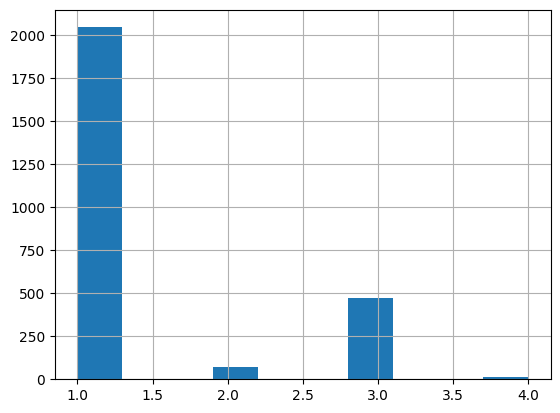

In [34]:
df["type"].hist()

## Making outputs

In [21]:
df['type'] = df["type"].map({
    "N": 1,
    "SVEB": 2,
    "VEB": 3,
    "F": 4
})

## Making x, y

In [22]:
X = df[["0_pre-RR" ,"0_qrs_interval"]]
y = df['type']

In [23]:
from imblearn.over_sampling import SMOTE



sm = SMOTE(random_state=0, sampling_strategy=sampling_strategy)
X, y = sm.fit_resample(X=X, y=y)

In [24]:
X = (X - X.mean()) / X.std()

In [25]:
y = y.map(
    {1: [1, 0, 0, 0], 2: [0, 1, 0, 0], 3: [0, 0, 1, 0], 4: [0, 0, 0, 1]}
)

In [26]:
y = np.array(y.tolist())

## Splitting data for training and testing

In [27]:
from sklearn.model_selection import train_test_split
import torch

X = torch.from_numpy(X.values).float()
y = torch.from_numpy(y).float()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1
)

## Arrhythmia Classifier

In [28]:
class Arrhythmia_classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(network_structure[0], network_structure[1])
        self.act1 = act1
        self.hidden2 = nn.Linear(network_structure[1],network_structure[2])
        self.act2 = act2
        self.output = nn.Linear(network_structure[2], network_structure[3])

    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x


model = Arrhythmia_classifier()
model

Arrhythmia_classifier(
  (hidden1): Linear(in_features=2, out_features=8, bias=True)
  (act1): Tanh()
  (hidden2): Linear(in_features=8, out_features=8, bias=True)
  (act2): Sigmoid()
  (output): Linear(in_features=8, out_features=4, bias=True)
)

In [29]:
import torch.optim as optim
import numpy as np
import random

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)
random.seed(10)

In [30]:
import tqdm
import copy


batches_per_epoch = len(X_train) // batch_size

best_acc = -np.inf  # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start : start + batch_size]
            y_batch = y_train[start : start + batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(loss=float(loss), acc=float(acc))
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}")

model.load_state_dict(best_weights)

Epoch 0:   6%|▌         | 70/1205 [00:00<00:07, 146.24batch/s, acc=0.5, loss=0.819]

Epoch 0: 100%|██████████| 1205/1205 [00:05<00:00, 233.21batch/s, acc=0.5, loss=1.32] 


Epoch 0 validation: Cross-entropy=0.44803643226623535, Accuracy=0.8210831880569458


Epoch 1: 100%|██████████| 1205/1205 [00:04<00:00, 283.01batch/s, acc=0.5, loss=1.15] 


Epoch 1 validation: Cross-entropy=0.39346954226493835, Accuracy=0.8588007688522339


Epoch 2: 100%|██████████| 1205/1205 [00:04<00:00, 292.67batch/s, acc=0.5, loss=1.15] 


Epoch 2 validation: Cross-entropy=0.38706856966018677, Accuracy=0.8684719800949097


Epoch 3: 100%|██████████| 1205/1205 [00:04<00:00, 283.81batch/s, acc=0.5, loss=1.06] 


Epoch 3 validation: Cross-entropy=0.3807404339313507, Accuracy=0.8675048351287842


Epoch 4: 100%|██████████| 1205/1205 [00:04<00:00, 272.56batch/s, acc=0.5, loss=0.902]


Epoch 4 validation: Cross-entropy=0.3776109218597412, Accuracy=0.8713732957839966


Epoch 5: 100%|██████████| 1205/1205 [00:04<00:00, 289.75batch/s, acc=0.5, loss=0.803]


Epoch 5 validation: Cross-entropy=0.37495511770248413, Accuracy=0.875241756439209


Epoch 6: 100%|██████████| 1205/1205 [00:04<00:00, 285.21batch/s, acc=0.5, loss=0.77] 


Epoch 6 validation: Cross-entropy=0.37462276220321655, Accuracy=0.875241756439209


Epoch 7: 100%|██████████| 1205/1205 [00:04<00:00, 286.74batch/s, acc=0.5, loss=0.756]


Epoch 7 validation: Cross-entropy=0.37420788407325745, Accuracy=0.8733075261116028


Epoch 8: 100%|██████████| 1205/1205 [00:04<00:00, 294.46batch/s, acc=0.5, loss=0.751]


Epoch 8 validation: Cross-entropy=0.3739457130432129, Accuracy=0.8723404407501221


Epoch 9: 100%|██████████| 1205/1205 [00:04<00:00, 273.51batch/s, acc=0.5, loss=0.745]


Epoch 9 validation: Cross-entropy=0.3742409646511078, Accuracy=0.8723404407501221


Epoch 10: 100%|██████████| 1205/1205 [00:04<00:00, 295.27batch/s, acc=0.5, loss=0.738]


Epoch 10 validation: Cross-entropy=0.37498122453689575, Accuracy=0.8694390654563904


Epoch 11: 100%|██████████| 1205/1205 [00:04<00:00, 282.22batch/s, acc=0.5, loss=0.732]


Epoch 11 validation: Cross-entropy=0.37593895196914673, Accuracy=0.8675048351287842


Epoch 12: 100%|██████████| 1205/1205 [00:04<00:00, 245.36batch/s, acc=0.5, loss=0.729]


Epoch 12 validation: Cross-entropy=0.37700706720352173, Accuracy=0.8675048351287842


Epoch 13: 100%|██████████| 1205/1205 [00:04<00:00, 259.65batch/s, acc=0.5, loss=0.729]


Epoch 13 validation: Cross-entropy=0.3781644105911255, Accuracy=0.8665376901626587


Epoch 14: 100%|██████████| 1205/1205 [00:04<00:00, 280.08batch/s, acc=0.5, loss=0.731]


Epoch 14 validation: Cross-entropy=0.37926965951919556, Accuracy=0.8684719800949097


Epoch 15: 100%|██████████| 1205/1205 [00:04<00:00, 289.45batch/s, acc=0.5, loss=0.733]


Epoch 15 validation: Cross-entropy=0.37997883558273315, Accuracy=0.8684719800949097


Epoch 16: 100%|██████████| 1205/1205 [00:04<00:00, 256.35batch/s, acc=0.5, loss=0.733]


Epoch 16 validation: Cross-entropy=0.3801262080669403, Accuracy=0.8694390654563904


Epoch 17: 100%|██████████| 1205/1205 [00:04<00:00, 290.16batch/s, acc=0.5, loss=0.732]


Epoch 17 validation: Cross-entropy=0.38067659735679626, Accuracy=0.8713732957839966


Epoch 18: 100%|██████████| 1205/1205 [00:04<00:00, 296.06batch/s, acc=0.5, loss=0.728]


Epoch 18 validation: Cross-entropy=0.3829081058502197, Accuracy=0.8723404407501221


Epoch 19: 100%|██████████| 1205/1205 [00:04<00:00, 296.86batch/s, acc=0.5, loss=0.721]


Epoch 19 validation: Cross-entropy=0.3842596411705017, Accuracy=0.8723404407501221


Epoch 20: 100%|██████████| 1205/1205 [00:04<00:00, 286.44batch/s, acc=0.5, loss=0.712]


Epoch 20 validation: Cross-entropy=0.3849042057991028, Accuracy=0.8733075261116028


Epoch 21: 100%|██████████| 1205/1205 [00:04<00:00, 257.86batch/s, acc=0.5, loss=0.703]


Epoch 21 validation: Cross-entropy=0.3851054012775421, Accuracy=0.8742746710777283


Epoch 22: 100%|██████████| 1205/1205 [00:04<00:00, 287.65batch/s, acc=0.5, loss=0.697]


Epoch 22 validation: Cross-entropy=0.3869917690753937, Accuracy=0.8723404407501221


Epoch 23: 100%|██████████| 1205/1205 [00:04<00:00, 294.84batch/s, acc=0.5, loss=0.696]


Epoch 23 validation: Cross-entropy=0.38994523882865906, Accuracy=0.8704062104225159


Epoch 24: 100%|██████████| 1205/1205 [00:04<00:00, 295.95batch/s, acc=0.5, loss=0.694]


Epoch 24 validation: Cross-entropy=0.3920518159866333, Accuracy=0.8704062104225159


Epoch 25: 100%|██████████| 1205/1205 [00:04<00:00, 295.33batch/s, acc=0.5, loss=0.688]


Epoch 25 validation: Cross-entropy=0.3925177752971649, Accuracy=0.8704062104225159


Epoch 26: 100%|██████████| 1205/1205 [00:04<00:00, 287.48batch/s, acc=0.5, loss=0.68] 


Epoch 26 validation: Cross-entropy=0.39364275336265564, Accuracy=0.8713732957839966


Epoch 27: 100%|██████████| 1205/1205 [00:03<00:00, 306.31batch/s, acc=0.5, loss=0.672]


Epoch 27 validation: Cross-entropy=0.39521798491477966, Accuracy=0.8723404407501221


Epoch 28: 100%|██████████| 1205/1205 [00:04<00:00, 284.26batch/s, acc=0.5, loss=0.665]


Epoch 28 validation: Cross-entropy=0.39673325419425964, Accuracy=0.8733075261116028


Epoch 29: 100%|██████████| 1205/1205 [00:04<00:00, 291.04batch/s, acc=0.5, loss=0.659]


Epoch 29 validation: Cross-entropy=0.39809030294418335, Accuracy=0.875241756439209


Epoch 30: 100%|██████████| 1205/1205 [00:04<00:00, 296.80batch/s, acc=0.5, loss=0.653]


Epoch 30 validation: Cross-entropy=0.39925771951675415, Accuracy=0.875241756439209


Epoch 31: 100%|██████████| 1205/1205 [00:04<00:00, 290.62batch/s, acc=0.5, loss=0.647]


Epoch 31 validation: Cross-entropy=0.40011295676231384, Accuracy=0.8742746710777283


Epoch 32: 100%|██████████| 1205/1205 [00:04<00:00, 299.93batch/s, acc=0.5, loss=0.641]


Epoch 32 validation: Cross-entropy=0.4005262553691864, Accuracy=0.875241756439209


Epoch 33: 100%|██████████| 1205/1205 [00:04<00:00, 291.52batch/s, acc=0.5, loss=0.635]


Epoch 33 validation: Cross-entropy=0.400633305311203, Accuracy=0.875241756439209


Epoch 34: 100%|██████████| 1205/1205 [00:04<00:00, 266.59batch/s, acc=0.5, loss=0.629]


Epoch 34 validation: Cross-entropy=0.4006587266921997, Accuracy=0.8771759867668152


Epoch 35: 100%|██████████| 1205/1205 [00:04<00:00, 247.01batch/s, acc=0.5, loss=0.621]


Epoch 35 validation: Cross-entropy=0.40063443779945374, Accuracy=0.8771759867668152


Epoch 36: 100%|██████████| 1205/1205 [00:04<00:00, 257.68batch/s, acc=0.5, loss=0.612]


Epoch 36 validation: Cross-entropy=0.40099436044692993, Accuracy=0.8791102766990662


Epoch 37: 100%|██████████| 1205/1205 [00:04<00:00, 294.10batch/s, acc=0.5, loss=0.604]


Epoch 37 validation: Cross-entropy=0.4019492566585541, Accuracy=0.8791102766990662


Epoch 38: 100%|██████████| 1205/1205 [00:04<00:00, 255.66batch/s, acc=0.5, loss=0.597]


Epoch 38 validation: Cross-entropy=0.40299752354621887, Accuracy=0.8781431317329407


Epoch 39: 100%|██████████| 1205/1205 [00:04<00:00, 283.79batch/s, acc=0.5, loss=0.59] 


Epoch 39 validation: Cross-entropy=0.40368813276290894, Accuracy=0.8781431317329407


Epoch 40: 100%|██████████| 1205/1205 [00:04<00:00, 294.78batch/s, acc=0.5, loss=0.585]


Epoch 40 validation: Cross-entropy=0.40392524003982544, Accuracy=0.8771759867668152


Epoch 41: 100%|██████████| 1205/1205 [00:04<00:00, 283.13batch/s, acc=0.5, loss=0.58] 


Epoch 41 validation: Cross-entropy=0.40415313839912415, Accuracy=0.8771759867668152


Epoch 42: 100%|██████████| 1205/1205 [00:04<00:00, 272.62batch/s, acc=0.5, loss=0.574]


Epoch 42 validation: Cross-entropy=0.40453028678894043, Accuracy=0.8771759867668152


Epoch 43: 100%|██████████| 1205/1205 [00:04<00:00, 273.50batch/s, acc=0.5, loss=0.568]


Epoch 43 validation: Cross-entropy=0.40481510758399963, Accuracy=0.8771759867668152


Epoch 44: 100%|██████████| 1205/1205 [00:04<00:00, 285.60batch/s, acc=0.5, loss=0.56] 

Epoch 44 validation: Cross-entropy=0.404987633228302, Accuracy=0.8781431317329407


<All keys matched successfully>

In [31]:
model.state_dict()

OrderedDict([('hidden1.weight',
              tensor([[-0.2554, -2.5126],
                      [-3.9421,  3.4729],
                      [ 6.8346, -0.3878],
                      [ 2.1663, -1.7082],
                      [ 0.9180, -0.1265],
                      [-4.7178, -1.7441],
                      [ 0.3332,  5.1868],
                      [-1.0795, -1.0924]])),
             ('hidden1.bias',
              tensor([ 2.9786,  0.2252, -1.8692,  0.6630, -2.3260, -0.2512,  0.2799, -1.5562])),
             ('hidden2.weight',
              tensor([[-1.2352, -2.8622,  3.4014,  0.2752,  3.4459,  1.7549, -3.1437, -3.4127],
                      [-1.3879,  3.3676, -0.5684, -1.5365,  0.4492, -3.2727,  1.4302,  3.1808],
                      [ 2.6378, -1.7342, -2.3064,  2.5429, -0.5219,  2.3141,  3.3010, -1.8963],
                      [-2.8337, -2.7868,  1.5712,  1.6171,  1.7040, -2.6955, -0.8881,  6.1641],
                      [ 0.9808, -1.4985, -1.9875,  2.9162, -1.0264,  1.6072, -0.7483, 

## Plotting Cross entropy and accuracy

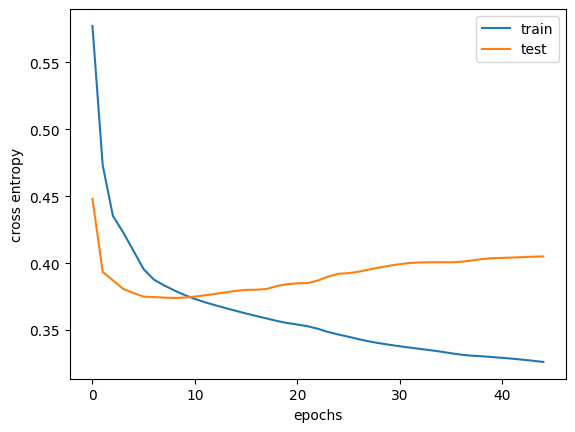

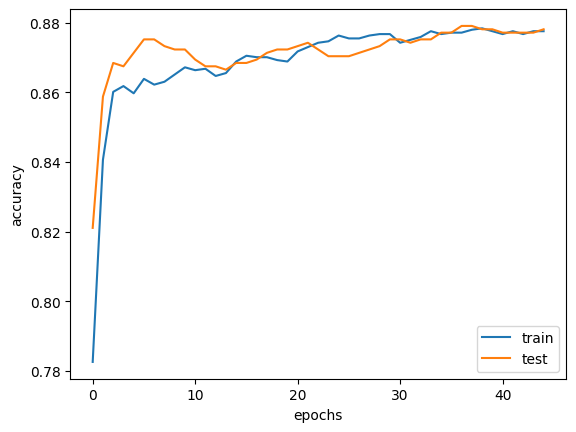

In [32]:
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.savefig(full_path)
plt.show()